# Dashboard for Prospective SCU MSIS Program students

#### Data used:

data about masters degree programs:  
https://nces.ed.gov/programs/digest/d16/tables/dt16_323.10.asp  
top 10 colleges for business majors:  
http://time.com/money/best-colleges/rankings/best-colleges-for-business-majors/  

SCU Linkedin Group member demographics

# Cleaning first dataset - Top 10 Colleges for Business Majors

import the web page

In [1]:
import urllib.request

socks = urllib.request.urlopen("http://time.com/money/best-colleges/rankings/best-colleges-for-business-majors/")
best4buis = socks.read()
socks.close()

from bs4 import BeautifulSoup
soup = BeautifulSoup(best4buis, "html.parser")

make dictionary of colleges with their ranks

In [3]:
  # List of colleges in order of ranking

colleges = []

for link in soup.find_all('a'):          # Searches for web links for each college
    colleges.append(link.get('href'))
    
      # Only list items from [10:60] are part of rankings. The rest are irrelevant
colleges = colleges[10:60]

    # keep only uni names, discard rest of web link
for i in range(0, len(colleges)):
    colleges[i] = colleges[i].split("/")[-2].replace("-", " ")

colleges_ranked = {}    # dictionary of colleges & rankings

for i in range(1, len(colleges)+1):
    colleges_ranked[colleges[i-1]] = i

Make dictionary of colleges with their detailed info

In [4]:
        # Data of each college; not in ranking order
uni_details = {}

        # filter out HTML to show college details only
uni_data = soup.find_all("div", "_2BD2P7tm")

for i in range(0, len(uni_data)):
    
        # Split the raw HTML dump of each college data
    uni = str(uni_data[i]).split("><")

        # university name grab
    uni_name = uni[4].split("<")
    uni_name = uni_name[-2].split(">")
    uni_name = uni_name[-1].replace("-", " ")
    uni_name = uni_name.replace("'", "")
    uni_name = uni_name.lower()

        # university city & state
    uni_city = uni[6].split('>')
    uni_city = uni_city[-1].split('<')
    uni_city = uni_city[0].split(",")
    uni_state = uni_city[1]
    uni_city = uni_city[0]
        
        # money (overall) rank
    uni_money = uni[-12].split('>')
    uni_money = uni_money[-1].split('<')
    uni_money = uni_money[0]
        
        # median ACT Score
    uni_SAT = uni[-7].split('-->')
    uni_SAT = uni_SAT[-1].split('<!--')
    uni_SAT = uni_SAT[0]

        # median SAT Score
    uni_ACT = uni[-5].split('-->')
    uni_ACT = uni_ACT[-1].split('<!--')
    uni_ACT = uni_ACT[0]
    
        # dictionary append
    uni_details[uni_name] = [uni_money, uni_city, uni_state, uni_SAT, uni_ACT]

'texas a and m university college station' key has typo.  lets fix that:

In [5]:
uni_details['texas a &amp; m university college station']

['34', 'College Station', ' TX', '1200', '27']

In [6]:
# delete from dictionary
del uni_details['texas a &amp; m university college station']
# append with new key
uni_details['texas a and m university college station'] = ['34', 'College Station', 'TX', '1200', '27']

'wheaton college' was also problematic:

In [7]:
uni_details['wheaton college']

['111', 'Wheaton', ' IL', '1300', '30']

In [8]:
# delete from dictionary
del uni_details['wheaton college']
# append with new key
uni_details['wheaton college illinois'] = ['111', 'Wheaton', 'IL', '1300', '30']

Write college details and ranking into CSV

In [10]:
    # two dictionaries: colleges_ranked and uni_details
    
o = open("top50_BusinessColleges.csv", 'w')

o.write("Name, Business School Rank, Overall Rank, City, State, Median SAT Score, Median ACT Score\n")

for i in colleges_ranked:
 line = str(i) + ", "
 line2 = str(colleges_ranked[i]) + ", "
 line3 = str(uni_details[i][0]) + ", "
 line4 = uni_details[i][1] + ", "
 line5 = uni_details[i][2] + ", "
 line6 = uni_details[i][3] + ", "
 line7 = uni_details[i][4]

 o.write(line + line2 + line3 + line4 + line5 + line6 + line7 + "\n")

o.close()

# Cleaning second dataset - Major Demographics

This set shows the number of college students studying each Major, sorted by year brackets

In [210]:
import pandas as pd

data = pd.ExcelFile("tabn323.10.xls")

In [211]:
data.sheet_names

['Digest 2016 Table 323.10']

In [212]:
df = data.parse('Digest 2016 Table 323.10')

In [213]:
df2 = df.drop([1,8,14,20,26,32,38,42,43,44,45,46,47])  # blank or useless rows dropped

In [214]:
header = df2.iloc[0]

In [170]:
df3 = df2[1:]

In [171]:
df4 = df3.rename(columns=header)

In [172]:
df4['Field of study'] = df4['Field of study'].str.replace('\n', "")
df4['Field of study'] = df4['Field of study'].str.strip('.')
df4['Field of study'] = df4['Field of study'].str.strip(' ')

In [173]:
df4 = df4.set_index(df4['Field of study'])

In [174]:
df5 = df4.T   # Switch X, Y axis for easier manipulation in Tableau

In [16]:
df5.to_csv("Major_Demographics.csv")

# Cleaning Third Dataset - SCU Alumni on LinkedIn

Statistics on SCU alumni in SCU's LinkedIn group are printed to a PDF to be scraped using pdfquery

In [2]:
import pdfquery as pdf

LinkedIn = pdf.PDFQuery("Linkedin_SCU_Alum_MGMT_InfoSystems.pdf")
LinkedIn.load()

Pull all data under 'Where they work' and 'what they are skilled at' Headings

In [3]:
Linkedin_Data = LinkedIn.extract([
        # ('with_parent','LTPage[page_index="0"]'), # PAGE Specifier if multiple pages in PDF
        ('with_formatter', 'text'),
        ('Where they work', ':in_bbox("200, 0, 380, 740")')])
DataDump = Linkedin_Data['Where they work'].split(' · ')
DataDump[0:8]

['22',
 'Santa Clara University 22',
 'Santa Clara University 11',
 'Cisco 11',
 'Cisco 11',
 'Apple 11',
 'Apple 8',
 'Google 8']

Remove odd numbered elements in list - query pulled duplicate headings and those are false values

In [231]:
DataDump2 = DataDump[1::2]

Split the dataset into their respective categories

In [232]:
WhatTheyreSkilledAt = DataDump2[15:]
WhereTheyWork = DataDump2[1:15] # Remove SCU from this set - assume it means they were students

In [233]:
WhereTheyWork

['Cisco 11',
 'Apple 11',
 'Google 8',
 'Accenture 6',
 'EY 6',
 'SAP 6',
 'Hewlett Packard Enterprise 5',
 'Deloitte 5',
 'Facebook 5',
 'ServiceNow 5',
 'VMware 4',
 'IBM 3',
 'Oracle 3',
 'PwC 3']

Split categories and number counts

In [234]:
for i in range(0, len(WhereTheyWork)):
    WhereTheyWork[i] = WhereTheyWork[i].rsplit(' ', 1)
                                                # Split based on last occurence of space
for i in range(0, len(WhatTheyreSkilledAt)):
    WhatTheyreSkilledAt[i] = WhatTheyreSkilledAt[i].rsplit(' ', 1)

In [235]:
import pandas as pd

df = pd.DataFrame(WhatTheyreSkilledAt)

In [236]:
headers = pd.Series(["","What Theyre Skilled at", "What #s"])

In [237]:
df = df.rename(columns=headers)

In [228]:
df.to_csv("SCU_Alumni.csv")

# Preliminary Visuals / Writeup:

My intent of this lab project is to show prospective students that Santa Clara University has a similar level of prestige among other well known California universities. Data to support my claim includes information on top 50 business schools in the USA and professional skills that SCU MSIS alumni state they hold in their LinkedIn profiles.

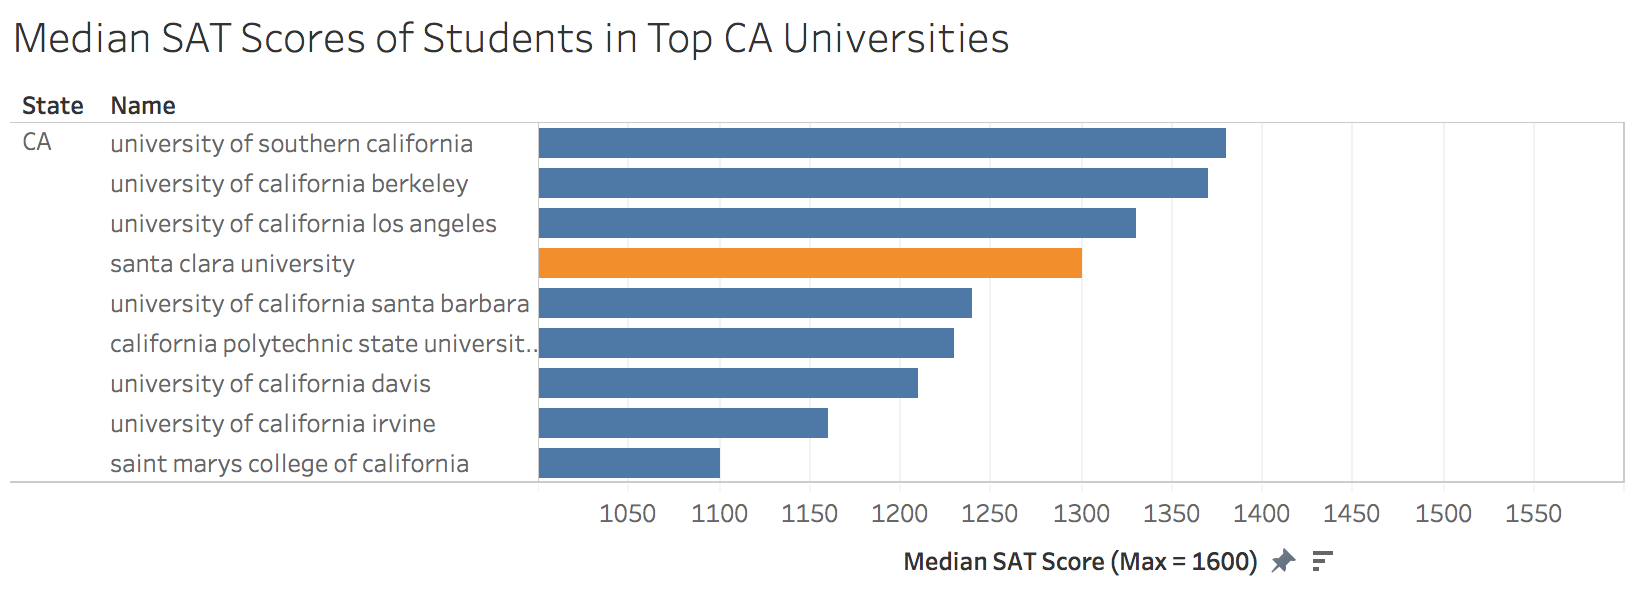

In [2]:
from IPython.core.display import Image 
Image(filename='/Users/melvinchow/Desktop/Lab4_1.png')

The above visual comes from data on the top 50 business schools in the USA.  There are many factors that can go into a ranking, many of which went unexplained in the dataset, so I decided to show only SAT scores of accepted students compared to other universities in the state. SAT scores by themselves can be enough information for a prospective student to gauge academic excellence among other schools in the area, because it is a necessary standardized test that every prospective college student in the USA must take for a chance to attend the college. A higher median score means the college tends to be stricter towards the intelligence levels of students they accept. This does NOT show the actual rankings of colleges given by the source, only the SAT scores.

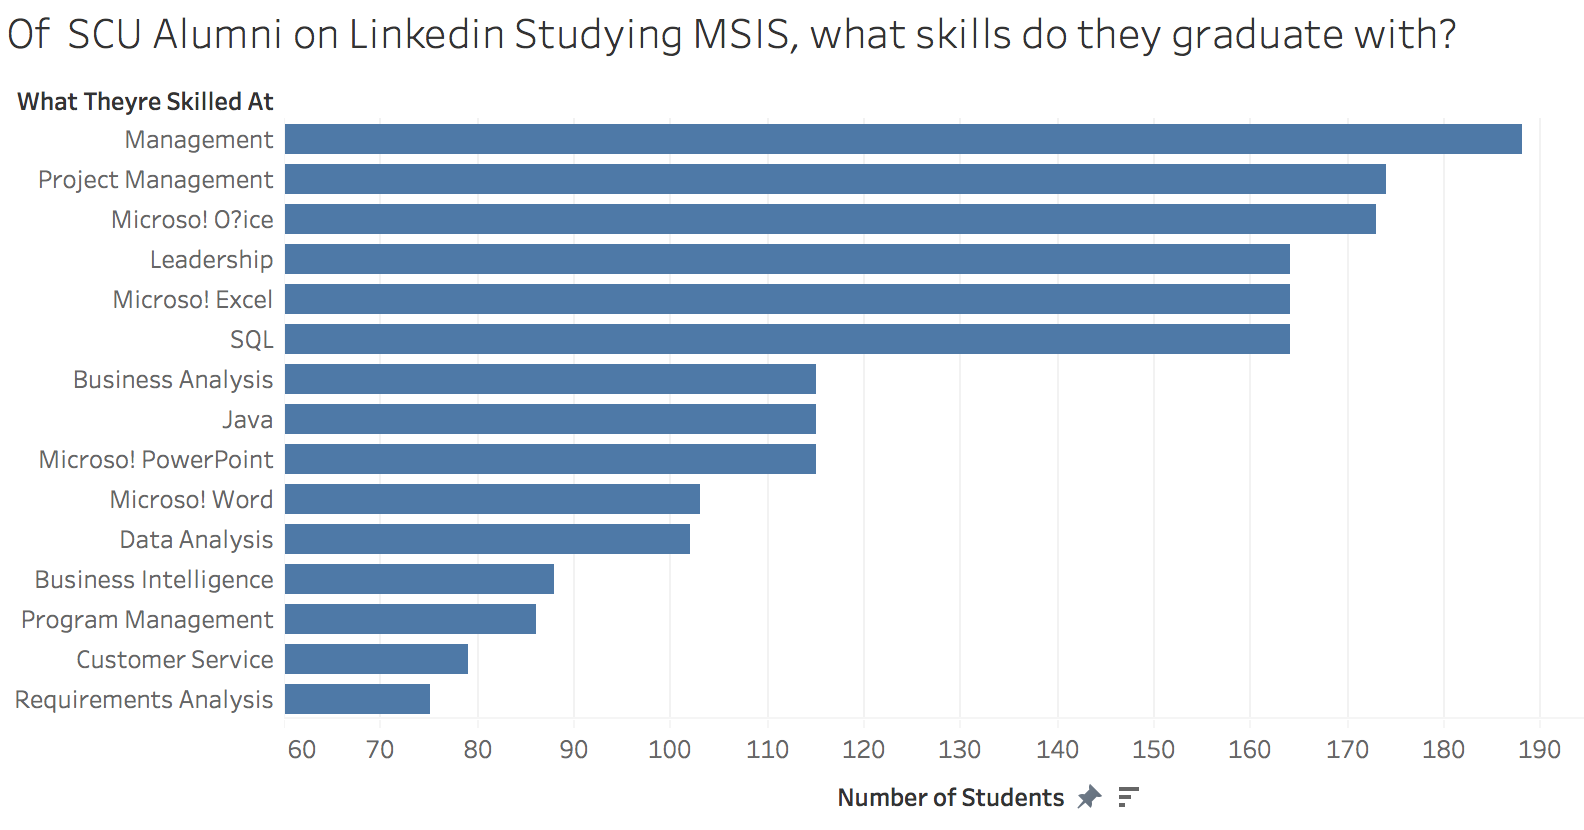

In [4]:
Image(filename='/Users/melvinchow/Desktop/Lab4_3.png')

On top of being a prestigious school, SCU Alumni studying MSIS or a similar program in SCU (if any) graduate from the program gaining many skills career advisors today would consider important and crucial to success in today's job market. If the categories near the top of this list are not interesting to the prospective student, they may want to look at a different school or program.

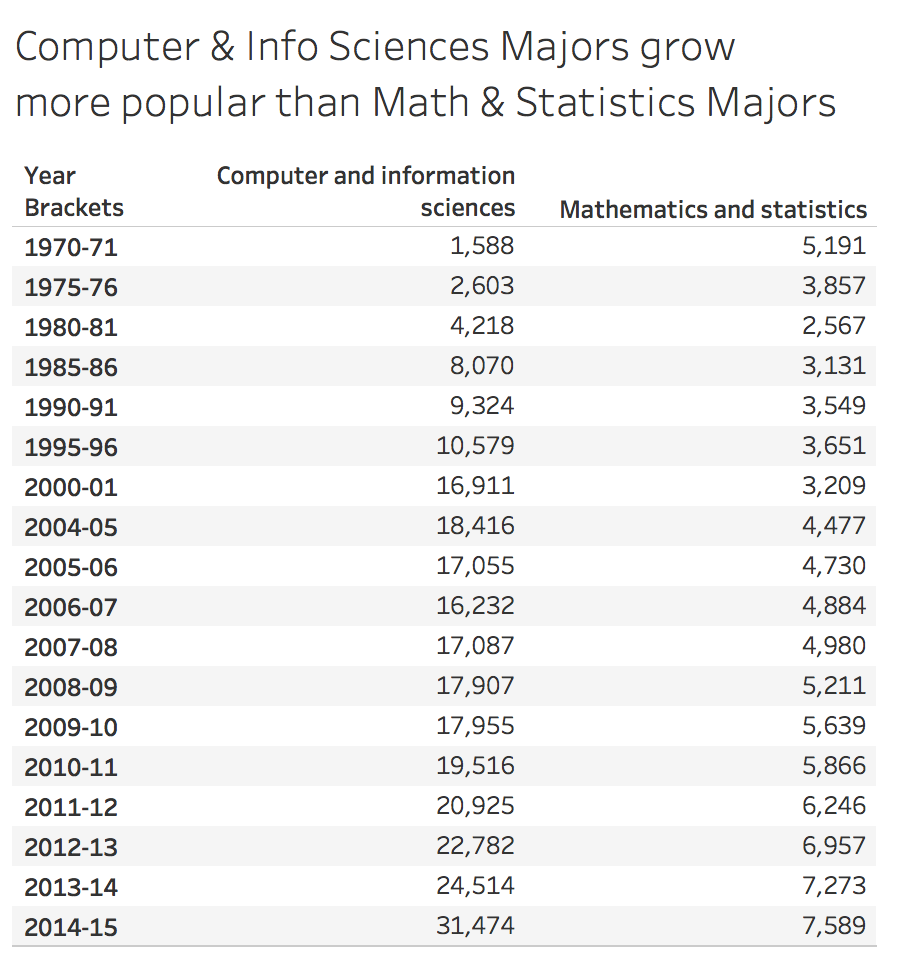

In [3]:
Image(filename='/Users/melvinchow/Desktop/Lab4_2.png')

MSIS program can fall under the category of Computer and Information Sciences among this dataset describing major popularity among all colleges in the USA; every other category deviate further from its relation to MSIS. Assume that the categories apply to both undergraduate and graduate students; because if data is possibly for undergraduates only it doesn't mean the value of the information is not applicable to graduate students.  

This data cannot be joined with data on universities, so this cannot back up my claim that SCU is a good school, but can back up a seperate claim stating MSIS is an increasingly valuable major for prospective students to pursue.

If I had more time, I would have scraped more LinkedIn data from other California universities to compare and contrast the alumni graduating from simlar programs in other colleges.